<a href="https://colab.research.google.com/github/aiden-dm/CSCI-4170/blob/main/CSCI_4170_Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projects in AI and ML - Homework 3**
##**Aiden Drover-Mattinen**

# Part 1

For this assignment, I chose to tackle the classic problem of identifying handwritten digits from images using the MNIST database. This dataset includes 60,000 training samples and 10,000 test samples of size-normalized handwritten digits. I selected this well-known and relatively clean dataset because I wanted to focus on understanding how neural networks work, without getting bogged down by complex, messy data.

This is my first experience working with neural networks, and I initially found them quite confusing. By choosing a straightforward problem, I aimed to simplify the learning process and build a strong foundational understanding. Additionally, since this is a computer vision problem, it complements the computer vision class I am currently taking at RPI. The skills I develop here will not only deepen my understanding of neural networks but also enhance my performance in that class.

Link to dataset: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

## Imports for code

In [1]:
# Imports
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Implementing a neural network from scratch

Conveniently, the MNIST dataset can be loaded directly from the Keras library as I've done below. It comes already divided into a training and a test set.

In [2]:
# Loading MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

Despite the data being relatively clean, some preprocessing was still necessary before using it in my neural network.

First, I reshaped the data so that each example was represented as a single column vector, with the number of rows corresponding to the number of training examples. Since the images are normalized to 28x28 pixels, I flattened each one into a column vector of length 784, where each pixel serves as a feature in the model.

Next, I normalized the pixel intensity values to a range between 0 and 1. As the images are in grayscale, dividing each pixel value by 255 achieved this normalization. Neural networks typically train more efficiently on normalized data.

Lastly, I performed one-hot encoding on the target labels. This process transforms the labels into column vectors of length 10, filled with zeros except for a single one at the index corresponding to the digit label. For example, a label of 5 would be represented as:

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0].T

I performed this one-hot encoding because the softmax activation function (which I will justify shortly) outputs probabilities across multiple classes, and one-hot encoding allows for a direct comparison between predicted outputs and true labels during model training.

Sources:
 * https://medium.com/towards-data-science/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d

In [3]:
# Ensure that the training data is in the shape (features, examples)
train_X = train_X.reshape(train_X.shape[0], -1).T
test_X = test_X.reshape(test_X.shape[0], -1).T

# Normalize light intensities in grayscale image
test_X = test_X / 255.0
train_X = train_X / 255.0

# Will use softmax, so y values will be one-hot encoded
train_y = to_categorical(train_y, num_classes=10).T
test_y = to_categorical(test_y, num_classes=10).T

# Print out the shapes to confirm they are correct
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (784, 60000)
Y_train: (10, 60000)
X_test:  (784, 10000)
Y_test:  (10, 10000)


Next I had to select and define the activation functions to be used in my network. I used the ReLU (Rectified Linear Unit) activation function in the hidden layer and the softmax activation function in the output layer.

ReLU is widely used because of its simplicity and effectiveness. It introduces non-linearity to the model, allowing it to learn complex patterns in the data. ReLU also helps mitigate the vanishing gradient problem, enabling faster and more efficient training by allowing gradients to propagate without diminishing quickly.

Softmax is ideal for multi-class classification problems like digit recognition because it converts the raw output scores into probabilities that sum to 1. This makes it easier to interpret the model’s predictions, as each output node represents the likelihood of the input image corresponding to a particular digit.

Sources:
* https://builtin.com/machine-learning/relu-activation-function#:~:text=What%20is%20ReLU%20used%20for,more%20complex%20relationships%20in%20data.
* https://www.analyticsvidhya.com/blog/2021/04/introduction-to-softmax-for-neural-network/

In [4]:
# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Define the derivative of the ReLU function to
# be used in the backpropagation algorithm
def relu_derivative(x):
    return (x > 0).astype(float)

# Define the softmax function
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

My next step was to write the neural network class. I implemented a network with a single hidden layer as it made the implementation more simple. The following is justification for the decisions to use He initialization for my weights, using mini-batch gradient descent, and using the Adam optimizer.

**He Initialization**:
He initialization was used to improve the performance of ReLU activation functions. By scaling weights with $\sqrt{\frac{2}{\text{input size}}}$, it maintains variance through layers, preventing vanishing or exploding gradients, and facilitating faster convergence.

**Mini-Batch Gradient Descent**:
Mini-batch gradient descent balances efficiency and stability. It processes subsets of data, reducing memory load and providing faster updates than full-batch, while introducing enough noise to help escape local minima compared to stochastic gradient descent. I hoped that this strategy would overcome any inefficiencies of writing the neural network myself.

**Adam Optimizer**:
The Adam optimizer combines momentum and adaptive learning rates, enabling efficient, stable convergence.

For my loss function, I chose **categorical cross entropy** because it is well-suited for multi-class classification tasks where the target labels are one-hot encoded. The categorical cross-entropy loss function effectively measures the discrepancy between the predicted probability distribution and the actual distribution of these one-hot encoded labels, facilitating efficient training of the neural network.

Sources:
* https://medium.com/@shauryagoel/kaiming-he-initialization-a8d9ed0b5899
* https://www.geeksforgeeks.org/adam-optimizer/
* https://medium.com/@shireenchand/choosing-between-cross-entropy-and-sparse-cross-entropy-the-only-guide-you-need-abea92c84662

In [5]:
# Create the neural network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        # Initialize biases
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((output_size, 1))

        # He initialization for weights for better ReLU performance
        self.W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2. / input_size)
        self.W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2. / hidden_size)

        # Adam optimizer parameters
        self.learning_rate = learning_rate
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # Initialize momentum values
        self.m_W1 = np.zeros_like(self.W1)
        self.m_b1 = np.zeros_like(self.b1)
        self.m_W2 = np.zeros_like(self.W2)
        self.m_b2 = np.zeros_like(self.b2)

        # Initialize velocity values
        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)

    # Forward propagation function
    def forward_propagation(self, X):
        # Create linear combination and apply ReLU for hidden layer
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = relu(self.Z1)

        # Create linear combination and apply softmax for output layer
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = softmax(self.Z2)

        return self.A2

    # Define the loss function (categorical cross entropy for this case)
    def categorical_cross_entropy(self, y_true, y_pred):
        # Small value added to avoid log(0)
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[1]
        return loss

    # Backward propagation function
    def backward_propagation(self, X, Y, Y_hat):
        # Get the number of samples
        m = X.shape[1]

        # Calculate derivatives for output layer
        dZ2 = Y_hat - Y
        dW2 = np.dot(dZ2, self.A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m

        # Calculate derivatives for hidden layer
        dZ1 = (np.dot(self.W2.T, dZ2) * relu_derivative(self.Z1))
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        # Return all derivatives (gradients)
        return dW1, db1, dW2, db2

    # Adam optimizer update
    def adam_optimizer(self, dW1, db1, dW2, db2):

        # Store gradients and corresponding moment and velocity references
        gradients = [dW1, db1, dW2, db2]
        moments = [self.m_W1, self.m_b1, self.m_W2, self.m_b2]
        velocities = [self.v_W1, self.v_b1, self.v_W2, self.v_b2]
        parameters = [self.W1, self.b1, self.W2, self.b2]

        # Update moment and velocity estimates
        for i in range(len(gradients)):
            moments[i] = self.beta1 * moments[i] + (1 - self.beta1) * gradients[i]
            velocities[i] = self.beta2 * velocities[i] + (1 - self.beta2) * (gradients[i] ** 2)

        # Bias corrections for moments and velocities
        m_hats = [m / (1 - self.beta1) for m in moments]
        v_hats = [v / (1 - self.beta2) for v in velocities]

        # Update parameters using corrected estimates
        for i in range(len(parameters)):
            parameters[i] -= self.learning_rate * m_hats[i] / (np.sqrt(v_hats[i]) + self.epsilon)

        # Update class attributes to maintain state across iterations
        self.m_W1, self.m_b1, self.m_W2, self.m_b2 = moments
        self.v_W1, self.v_b1, self.v_W2, self.v_b2 = velocities
        self.W1, self.b1, self.W2, self.b2 = parameters

    # Gradient descent function
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=64):

        for epoch in range(epochs):
        # Shuffle training data for better generalization
          num_batches = X_train.shape[1] // batch_size

          for batch in range(num_batches):
              # Get mini-batch of training data
              start = batch * batch_size
              end = (batch + 1) * batch_size
              X_batch = X_train[:, start:end]
              Y_batch = Y_train[:, start:end]

              # Perform forward propagation
              Y_hat = self.forward_propagation(X_batch)

              # Calculate loss with mini-batch
              loss = self.categorical_cross_entropy(Y_batch, Y_hat)

              # Backward propagation to get gradients
              dW1, db1, dW2, db2 = self.backward_propagation(X_batch, Y_batch, Y_hat)

              # Update parameters with Adam optimizer
              self.adam_optimizer(dW1, db1, dW2, db2)

          # Calculate accuracy for current epoch
          Y_pred = self.predict(X_test)
          Y_actual = np.argmax(Y_test, axis=0)
          accuracy = np.mean(Y_pred == Y_actual) * 100

          # Print the loss and accuracy at the end of each epoch
          print(f"Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy:.2f}%")


    # Function that gets the predictions for the model on inputted data
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=0)

To verify that my model was working correctly, I assigned the input parameters to variables, created a NeuralNetwork object, and trained it on the training set. I determined the hidden layer size and learning rate through trial and error during debugging, which resulted in good performance and kept the training time reasonable. I ran the model for 15 epochs to allow sufficient time for convergence and printed the loss and accuracy at each epoch to monitor its progress in real time.

In [6]:
# Parameters
input_size = 784       # For MNIST (28x28 images)
hidden_size = 128      # First hidden layer neurons
output_size = 10       # Number of output classes (digits 0-9)
learning_rate = 0.001  # Learning rate for Adam optimizer

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

# Training parameters
epochs = 15            # More epochs for better convergence
batch_size = 64        # Mini-batch size

# Train the model
nn.train(train_X, train_y, test_X, test_y, epochs=epochs, batch_size=batch_size)


Epoch 0, Loss: 0.3547616778608269, Accuracy: 94.46%
Epoch 1, Loss: 0.32725486594891884, Accuracy: 95.56%
Epoch 2, Loss: 0.31266779973693426, Accuracy: 96.16%
Epoch 3, Loss: 0.3001264506697317, Accuracy: 96.52%
Epoch 4, Loss: 0.28867739800733405, Accuracy: 96.86%
Epoch 5, Loss: 0.2792358683392269, Accuracy: 97.02%
Epoch 6, Loss: 0.2709056031416237, Accuracy: 97.13%
Epoch 7, Loss: 0.2633955994250666, Accuracy: 97.19%
Epoch 8, Loss: 0.2533194470871217, Accuracy: 97.29%
Epoch 9, Loss: 0.24417237831647562, Accuracy: 97.35%
Epoch 10, Loss: 0.2343513580678401, Accuracy: 97.45%
Epoch 11, Loss: 0.22455291097411886, Accuracy: 97.52%
Epoch 12, Loss: 0.215267781916624, Accuracy: 97.59%
Epoch 13, Loss: 0.2053334018259039, Accuracy: 97.63%
Epoch 14, Loss: 0.196132603738197, Accuracy: 97.62%


In the following code, I demonstrate that my trained model achieves a high accuracy score on the test data using my predict() function.

In [7]:
# Generating predictions for the test set
predictions = nn.predict(test_X)
actual = np.argmax(test_y, axis=0)
accuracy = np.mean(predictions == actual) * 100

# Printing the predictions side by side and the accuracy
print("Predictions:", predictions)
print("Actual:", actual)
print(f"Accuracy: {accuracy}%")

Predictions: [7 2 1 ... 4 5 6]
Actual: [7 2 1 ... 4 5 6]
Accuracy: 97.61999999999999%


# Part 2

## Task 1: Materials Used

I chose to use TensorFlow as my deep learning library to implement my two-hidden-layer neural network because it is a widely recognized framework with easy-to-use functions for creating, training, and testing models.

The first resource I used was the official documentation on "The Sequential Model" from TensorFlow. This mini-tutorial explains how to create a neural network using the Sequential model, which is "appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor." This approach perfectly fits the needs of my project. Additionally, it introduced me to Keras, TensorFlow's high-level API that dramatically simplifies the syntax and makes building neural networks approachable. Essentially, you create a model object, define the neuron layers (specifying the number of layers and their activation functions), compile the model by choosing an optimizer and a loss function, and then train and optimize the model using straightforward function calls.

Source: https://www.tensorflow.org/guide/keras/sequential_model

The next resource I used was also from the official TensorFlow documentation. It provides in-depth examples on how to train and evaluate a neural network using functions like .fit() and .evaluate(). It also describes .predict(), which performs a forward propagation step to generate predictions without updating any model weights.

Source: https://www.tensorflow.org/guide/keras/training_with_built_in_methods

Another valuable resource was the official TensorFlow documentation on optimizers. I referred to this to understand how to implement and compare the performance of different optimizers—Momentum, RMSProp, and Adam—in my experiments.

Source: https://keras.io/api/optimizers/

The final resource I used extensively was the sklearn documentation. Although TensorFlow's .evaluate() function provides basic performance measures, I wanted more detailed metrics. Sklearn's classification report computes and presents accuracy, precision, recall, and F1-score in an easy-to-digest table, which was extremely useful for displaying the results of my hyperparameter experiments.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


## Task 2: Implementing 2 Hidden-Layer Neural Network

### Exploratory Data Analysis

As done earlier, we will be importing the MNIST database as follows:

In [8]:
# Loading MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

To get a better feel for the data, we can print out the shapes of the training and test sets.

In [9]:
# Printing data shapes
print(f"Training data shape: {train_X.shape}")
print(f"Test data shape: {test_X.shape}")
print(f"Training labels shape: {train_y.shape}")
print(f"Test labels shape: {test_y.shape}")

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Training labels shape: (60000,)
Test labels shape: (10000,)


Conveniently, MNIST does not contain any missing values, making preprocessing very simple. We can confirm that there are no missing values as follows:

In [10]:
# Checking if there are any missing values
print(f"Any missing values? {np.isnan(train_X).sum()}")

Any missing values? 0


To better understand what the model will be training on, we should print some of the test images to see what they look like. According to the data shape, they should be 28x28 pixels. We also know that they should be grayscale images. We can confirm this using matplotlib as shown below:

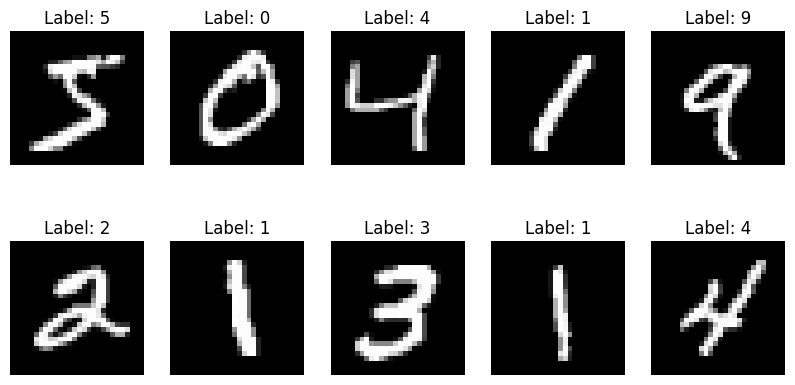

In [11]:
# Plotting a few test images using matplotlib
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_X[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {train_y[i]}")
    plt.axis('off')
plt.show()


We can also check the distribution of the labels. This is important as it can reveal if there is any bias in the data with certain labels being overrepresented. We can do this using a histogram as performed below:

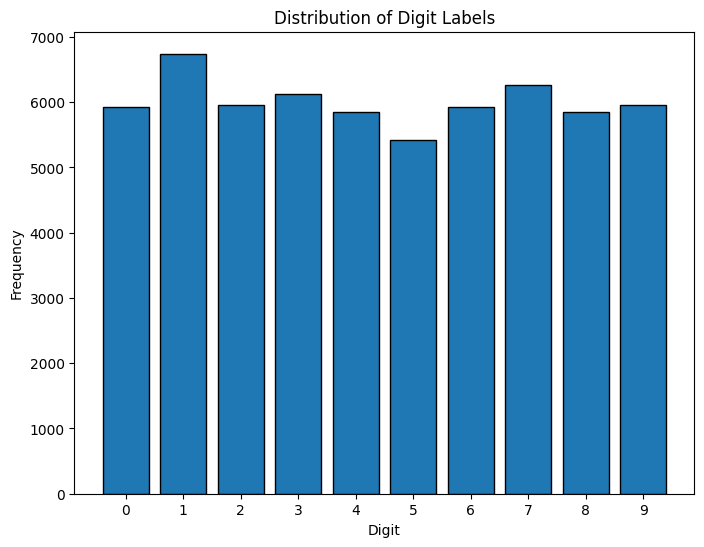

In [12]:
plt.figure(figsize=(8,6))
plt.hist(train_y, bins=np.arange(11)-0.5, edgecolor='black', rwidth=0.8)
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Distribution of Digit Labels')
plt.xticks(range(10))
plt.show()

It can be seen that the distribution of digit labels is relatively balanced. As a result, I do not think that it is necessary to add/remove examples to/from the dataset.

Next, we can analyze the pixel intensity values of the image. This can be done using a histogram to visualize the distribution of the intensity values across the training set.

Pixel value range: 0 to 255


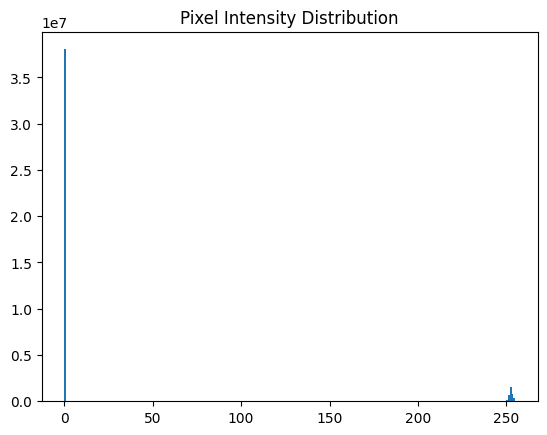

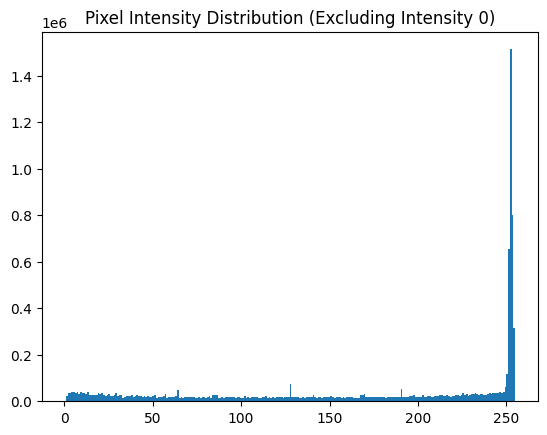

In [13]:
# Print the min and max pixel intensity values
print(f"Pixel value range: {train_X.min()} to {train_X.max()}")

# Flatten the test images to get array of intensity values
intensity_values = train_X.flatten()

# Create a histogram showing the distribution of pixel intensities
plt.hist(intensity_values, bins=256, range=(0, 255), fc='black', ec='black')
plt.title('Pixel Intensity Distribution')
plt.show()

# Remove the 0 values from the array then print the histogram again
intensity_values = intensity_values[intensity_values != 0]
plt.hist(intensity_values, bins=256, range=(0, 255), fc='black', ec='black')
plt.title('Pixel Intensity Distribution (Excluding Intensity 0)')
plt.show()

The first histogram clearly shows that most pixel intensities in the dataset are 0, which obscures the distribution of the remaining values. To better visualize the non-zero data, I created a second histogram that excludes the 0 values. This revised plot reveals that most of the positive intensity values are clustered near the maximum value of 255, indicating that the pixel intensities are almost binary—predominantly at the lower bound (0) or near the upper bound (255).

Lastly, we can check if there are any duplicate images in the training set. We can do this using a DataFrame from the pandas library. It can be seen that there are no duplicates, again making preprocessing very easy.

In [14]:
duplicates = pd.DataFrame(train_X.reshape(train_X.shape[0], -1)).duplicated().sum()
print(f"Number of duplicate images: {duplicates}")

Number of duplicate images: 0


### Performing a Train-Dev-Test Split

Since the MNIST dataset already comes with predefined training and test sets, the remaining step is to carve out a portion of the training data to serve as a development (dev) set. I allocated 15% of the training set for this purpose, resulting in a dev set of 9,000 examples, which is comparable in size to the test set. This dev set will be used to fine-tune hyperparameters and evaluate model performance before final testing.

In [15]:
# Splitting the training data into training and dev
train_X_split, dev_X, train_y_split, dev_y = train_test_split(train_X, train_y, test_size=0.15, random_state=42)

# Print the shapes of all the datasets
print("Dataset Shapes:")
print(f"Training SetX: {train_X_split.shape}")
print(f"Training SetY: {train_y_split.shape}")
print(f"Dev SetX: {dev_X.shape}")
print(f"Dev SetY: {dev_y.shape}")
print(f"Test SetX: {test_X.shape}")
print(f"Test SetY: {test_y.shape}")

Dataset Shapes:
Training SetX: (51000, 28, 28)
Training SetY: (51000,)
Dev SetX: (9000, 28, 28)
Dev SetY: (9000,)
Test SetX: (10000, 28, 28)
Test SetY: (10000,)


Like in Part 1, I also want collapse the 28x28 test images into 784 vectors to be used in the neural network. This is done as follows:

In [16]:
# Ensure that the training data is in the shape (features, examples)
train_X_split = train_X_split.reshape(train_X_split.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
dev_X = dev_X.reshape(dev_X.shape[0], -1)

# Print the shapes to confirm
print('X_train: ' + str(train_X_split.shape))
print('X_test:  '  + str(test_X.shape))
print('X_dev:  '  + str(dev_X.shape))

X_train: (51000, 784)
X_test:  (10000, 784)
X_dev:  (9000, 784)


### Implementing Forward Propagation

The next step is to implement forward propagation. Rather than building the neural network from scratch, I will use TensorFlow, a widely recognized deep learning framework. Additionally, I will utilize Keras, TensorFlow's high-level API, which simplifies syntax and enhances readability.

In [17]:
# Define the shape of the model
input_shape = (train_X_split.shape[1],)

# Creating the neural network model with TensorFlow
model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile the Adam optimizer into the network
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

The above code defines and compiles a neural network model. The model is sequential, consisting of two hidden layers with 64 neurons each, using the ReLU activation function, followed by an output layer with 10 neurons and a softmax activation to classify the MNIST digits. The input shape is based on the dimensions of the training data. The model is compiled with the Adam optimizer, using sparse categorical crossentropy as the loss function, and accuracy as the evaluation metric.

I chose to use ReLU, softmax, and adam for the same reasons that I used them for Part 1, as summarized below:
* ReLU is used because it introduces non-linearity, enabling the model to learn complex patterns and mitigating the vanishing gradient problem for faster training.
* Softmax is ideal for multi-class classification as it converts output scores into probabilities, simplifying interpretation of predictions.
* The Adam optimizer was chosen for its adaptive learning rate and efficient performance, leading to faster convergence.

I switched to the sparse categorical cross-entropy loss function for my MNIST classification neural network because it is ideal for multi-class classification tasks where labels are integers instead of one-hot encoded vectors. In the MNIST dataset, each image is labeled with an integer from 0 to 9. This loss function directly compares the model's predicted probabilities with these integer labels, simplifying the implementation by removing the need to convert labels into one-hot encoded format.

Source:
* https://medium.com/@shireenchand/choosing-between-cross-entropy-and-sparse-cross-entropy-the-only-guide-you-need-abea92c84662

With the model created, I can now perform forward propagation using the following code. We can do some investigation by printing out performance metrics for the untrained model:

In [18]:
# Get predictions
predictions = model.predict(dev_X)
predicted_classes = predictions.argmax(axis=1)

# Detailed classification report
print("Classification Report:")
print(classification_report(dev_y, predicted_classes))

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.03      0.05       891
           1       0.12      0.98      0.21       991
           2       0.00      0.00      0.00       896
           3       0.05      0.01      0.02       904
           4       0.06      0.00      0.01       872
           5       0.03      0.01      0.01       827
           6       0.00      0.00      0.00       878
           7       0.00      0.00      0.00       963
           8       0.12      0.01      0.02       865
           9       0.12      0.00      0.00       913

    accuracy                           0.11      9000
   macro avg       0.07      0.10      0.03      9000
weighted avg       0.07      0.11      0.03      9000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can see that the scores for precision, recall, f1-score and accuracy are not good whatsoever. This is to be expected because we are making predictions without doing any training yet.

### Gradient Descent Implementation

Now its time to implement gradient descent:

In [19]:
# Train the model
losses = model.fit(train_X_split, train_y_split,
                   validation_data=(dev_X, dev_y),
                   batch_size=256,
                   epochs=15,
                   )

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6119 - loss: 17.7836 - val_accuracy: 0.8451 - val_loss: 1.4409
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8698 - loss: 1.0894 - val_accuracy: 0.8702 - val_loss: 0.8631
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8912 - loss: 0.6298 - val_accuracy: 0.8959 - val_loss: 0.5842
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9143 - loss: 0.4180 - val_accuracy: 0.9078 - val_loss: 0.4847
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9275 - loss: 0.3095 - val_accuracy: 0.9148 - val_loss: 0.4225
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9373 - loss: 0.2494 - val_accuracy: 0.9128 - val_loss: 0.4304
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9428 - loss: 0.2205 - val_accuracy: 0.9207 - val_loss: 0.3954
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9477 - loss: 0.1924 - val_accuracy: 

We can print the loss calculations as the decrease throughout the epochs, resulting in the final computation of the loss function:

In [20]:
# Printing the losses calculated throughout training
print(f"Array of losses {losses.history['loss']}")
print(f"Final loss value: {losses.history['loss'][-1]}")

Array of losses [6.14089298248291, 0.9773024916648865, 0.5853509306907654, 0.4135166108608246, 0.3173213601112366, 0.2600937485694885, 0.23022332787513733, 0.19346584379673004, 0.1694423258304596, 0.1544092446565628, 0.14570283889770508, 0.13265559077262878, 0.12797583639621735, 0.12361510097980499, 0.11371169239282608]
Final loss value: 0.11371169239282608


### Experimentation

#### Different optimization algorithms

Although I used the adam optimizer in my original implementation, I simply assumed it would be the best performing since its includes the characteristics of both Momentum and RMSProp. However, it is worth testing the network with the other two optimizers to see if they produce better results.

In [21]:
# Function used to test Momentum, RMSProp and Adam optimizers
def test_optimizers(train_X, train_y, test_X, test_y):
    # Create optimizer objects and store their names
    optimizers = [tf.keras.optimizers.Adam(),
                  tf.keras.optimizers.SGD(momentum=0.9),
                  tf.keras.optimizers.RMSprop()]
    optimizer_names = ['Adam', 'Momentum', 'RMSProp']

    # Define the shape of the input data
    input_shape = (train_X.shape[1],)

    # Train and evaluate each optimizer
    for optimizer, name in zip(optimizers, optimizer_names):
        # Initialize a new model instance for each optimizer
        model = tf.keras.Sequential([
            tf.keras.Input(shape=input_shape),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=10, activation='softmax')
        ])

        # Compile the model with the current optimizer
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
        print(f"Optimizer: {name}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Generate predictions
        predictions = model.predict(test_X)
        predicted_classes = predictions.argmax(axis=1)

        # Classification report
        print(f"Classification Report for {name}:")
        print(classification_report(test_y, predicted_classes))

# Run the function
test_optimizers(train_X_split, train_y_split, dev_X, dev_y)

Optimizer: Adam
Test Accuracy: 0.9608
Test Loss: 0.1638
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report for Adam:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       891
           1       0.98      0.99      0.98       991
           2       0.94      0.95      0.95       896
           3       0.94      0.96      0.95       904
           4       0.94      0.98      0.96       872
           5       0.97      0.95      0.96       827
           6       0.99      0.95      0.97       878
           7       0.95      0.98      0.96       963
           8       0.97      0.94      0.95       865
           9       0.96      0.92      0.94       913

    accuracy                           0.96      9000
   macro avg       0.96      0.96      0.96      9000
weighted avg       0.96      0.96      0.96      9000

Optimizer: Momentum
Test Accuracy: 0.1101
Test Loss: 2.3017
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classificat

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Optimizer: RMSProp
Test Accuracy: 0.9471
Test Loss: 0.3387
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for RMSProp:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       891
           1       0.98      0.96      0.97       991
           2       0.93      0.96      0.95       896
           3       0.94      0.94      0.94       904
           4       0.99      0.92      0.95       872
           5       0.96      0.91      0.93       827
           6       0.95      0.97      0.96       878
           7       0.96      0.96      0.96       963
           8       0.84      0.96      0.90       865
           9       0.96      0.92      0.94       913

    accuracy                           0.95      9000
   macro avg       0.95      0.95      0.95      9000
weighted avg       0.95      0.95      0.95      9000



The results indicate that the model performed best with Adam and RMSProp optimizers, both achieving high test accuracy and low test loss with consistently strong classification metrics across all classes. In contrast, using the Momentum optimizer resulted in extremely poor performance, with very low accuracy and high loss, suggesting that it failed to learn effectively—likely due to suboptimal hyperparameters. Overall, these findings suggest that for this MNIST classification task, Adam and RMSProp are much more effective than Momentum.

For my final implementation, I will continue to use Adam as it has all the functionality of RMSProp with additional functionality. Additionally, Adam's added complexity does not seem to be negatively impacting the training time of the network.

#### Different numbers of hidden layers

I also wanted to test different numbers of hidden layers to see if performance could be improved. With more hidden layers, more complex relationships can be captured by the model, however, the risk of overfitting becomes greater. The following is the code I used to test different hidden layer structures.

In [22]:
# Function used to test different numbers of hidden layers
def test_layers(train_X, train_y, test_X, test_y):
    input_shape = (train_X.shape[1],)
    layers = [1, 2, 3]

    for layer_count in layers:
        # Initialize a new model
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=input_shape))

        # Add the specified number of hidden layers
        for _ in range(layer_count):
            model.add(tf.keras.layers.Dense(units=64, activation='relu'))

        # Output layer
        model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=1)
        print(f"Number of Hidden Layers: {layer_count}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Generate predictions
        predictions = model.predict(test_X)
        predicted_classes = predictions.argmax(axis=1)

        # Classification report
        print(f"Classification Report for {layer_count} Hidden Layers:")
        print(classification_report(test_y, predicted_classes))

# Run the function
test_layers(train_X_split, train_y_split, dev_X, dev_y)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9329 - loss: 0.2688
Number of Hidden Layers: 1
Test Accuracy: 0.9327
Test Loss: 0.2764
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report for 1 Hidden Layers:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       891
           1       0.98      0.97      0.97       991
           2       0.92      0.92      0.92       896
           3       0.93      0.89      0.91       904
           4       0.97      0.92      0.94       872
           5       0.97      0.87      0.92       827
           6       0.95      0.96      0.96       878
           7       0.97      0.93      0.95       963
           8       0.80      0.94      0.87       865
           9       0.88      0.96      0.92       913

    accuracy                           0.93      9000
   macro avg       0.94      0.93      0.93      9000
weighted avg       0.94      0.93      0.93      9000

282/282 ━━━━━━━

Based on our tests, the model with three hidden layers achieved the best overall performance, yielding higher test accuracy and lower test loss than the one- and two-hidden-layer configurations. The classification report for the three-hidden-layer model also showed consistently strong performance across all digit classes, suggesting that the extra depth helped capture more complex patterns and improved generalization.

#### Normalizing pixel intensities

As I did in Part 1, I normalized the pixel intensity values to a range between 0 and 1. In theory, this normalization should speed up the training process and yield better results by ensuring that the input features are on a similar scale. However, for training on MNIST, we can perform an experiment to determine whether normalization actually makes a significant impact on performance.

In [26]:
# Helper function to build and compile the model
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Defining the input shape
input_shape = (train_X_split.shape[1],)

# Train on unnormalized data
print("Training on unnormalized data:")
model1 = create_model(input_shape)
model1.fit(train_X_split, train_y_split, epochs=10, batch_size=32, verbose=0)
test_loss, test_accuracy = model1.evaluate(dev_X, dev_y, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
predictions = model1.predict(dev_X)
predicted_classes = predictions.argmax(axis=1)
print("Classification Report for unnormalized data:")
print(classification_report(dev_y, predicted_classes))

# Train on normalized data (pixel values scaled to [0,1])
print("\nTraining on normalized data:")
X_train_norm = train_X_split / 255.0
X_dev_norm = dev_X / 255.0
model2 = create_model(input_shape)
model2.fit(X_train_norm, train_y_split, epochs=10, batch_size=32, verbose=0)
test_loss, test_accuracy = model2.evaluate(X_dev_norm, dev_y, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
predictions = model2.predict(X_dev_norm)
predicted_classes = predictions.argmax(axis=1)
print("Classification Report for normalized data:")
print(classification_report(dev_y, predicted_classes))



Training on unnormalized data:
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9630 - loss: 0.1670
Test Accuracy: 0.9650
Test Loss: 0.1486
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for unnormalized data:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       891
           1       0.99      0.98      0.99       991
           2       0.96      0.97      0.96       896
           3       0.96      0.96      0.96       904
           4       0.95      0.98      0.96       872
           5       0.97      0.95      0.96       827
           6       0.97      0.97      0.97       878
           7       0.98      0.96      0.97       963
           8       0.93      0.95      0.94       865
           9       0.95      0.95      0.95       913

    accuracy                           0.96      9000
   macro avg       0.96      0.96      0.96      9000
weighted avg       0.97      0.96      0.97      9000


Training

From the experiment we can conclude that the model trained on the normalized data performed better. Normalizing the pixel values led to higher test accuracy, lower test loss, and improved classification metrics (precision, recall, and F1-scores) across all classes compared to training on unnormalized data.

### Presenting the Final Results

After all the experimentation, we can combine the best performing characteristics and test the network on the test dataset. The following neural network will have:

* 3 hidden layers
* Adam optimization algorithm
* Normalizing the data

Finally we can move on from the dev dataset and see how the model performs on new data!

In [25]:
# Normalizing the data
X_tr = train_X_split / 255.0
X_ts = test_X / 255.0

# Initialize a new model instance for each optimizer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile the model with the current optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_tr, train_y_split, epochs=10, batch_size=32, verbose=1)

# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(X_ts, test_y, verbose=1)
predictions = model.predict(X_ts)
predicted_classes = predictions.argmax(axis=1)
print("Classification Report:")
print(classification_report(test_y, predicted_classes))

Epoch 1/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8423 - loss: 0.5152
Epoch 2/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9579 - loss: 0.1362
Epoch 3/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9697 - loss: 0.0952
Epoch 4/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9774 - loss: 0.0733
Epoch 5/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9826 - loss: 0.0557
Epoch 6/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9837 - loss: 0.0496
Epoch 7/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9856 - loss: 0.0425
Epoch 8/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9882 - loss: 0.0349
Epoch 9/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9901 - loss: 0.0321
Epoch 10/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9915 - loss: 0.0259
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9707 - loss: 0.1124
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Cla

Using the best hyperparameters, the resulting model achieved strong performance on the MNIST dataset, with approximately 97% accuracy and excellent precision, recall, and F1-scores across all classes. While the basic neural network proved to be an effective choice for this task, certain simplifications—such as flattening the 28x28 images—limit its ability to capture the spatial relationships between pixels. Advanced techniques, like convolutional neural networks, preserve the original image structure and can better exploit these spatial relationships, potentially leading to even greater performance improvements.

# Statement About Use of Generative AI

Throughout this project, I leveraged generative AI models to help refine the structure and grammar of my writing. I also used them to format some of my code for better readability and consulted them for guidance on which TensorFlow functions, and other functions to use before researching and implementing them myself. All content presented is my own, and any external sources referenced for this assignment are properly cited or linked where appropriate. I wasn't sure of the exact citation format for AI usage, so I felt this paragraph would suffice.

I thoroughly enjoyed completing this assignment and deepening my understanding of so many new concepts!